In [1]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-double-embed/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, arrange_data, get_field
from nn_models import MLP, PSD
from hnn import HNN_structure_embed
from utils import L2_loss, from_pickle


In [2]:
DPI = 300
FORMAT = 'png'

def get_args():
    return {'num_angle': 2,
         'nonlinearity': 'tanh',
         'name': 'pend',
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 5,
         'gpu': 0,
         'solver': 'dopri5'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())


 ## Load models

In [3]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, naive, damping, num_points):
    M_net = PSD(2*args.num_angle, 400, args.num_angle).to(device)
    g_net = MLP(2*args.num_angle, 300, args.num_angle).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 3 * args.num_angle + 1
            output_dim = 3 * args.num_angle
            nn_model = MLP(input_dim, 1200, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_embed(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive)
        elif baseline:
            input_dim = 3 * args.num_angle + 1
            output_dim = 2 * args.num_angle
            nn_model = MLP(input_dim, 800, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_embed(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive)
        else:
            input_dim = 3 * args.num_angle
            output_dim = 1
            nn_model = MLP(input_dim, 600, output_dim, args.nonlinearity).to(device)
            model = HNN_structure_embed(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(2*args.num_angle, 300, 1).to(device)
        model = HNN_structure_embed(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

naive_ode_model, naive_ode_stats = get_model(args, baseline=False, structure=False, naive=True, damping=False, num_points=args.num_points)
base_ode_model, base_ode_stats = get_model(args, baseline=True, structure=False, naive=False, damping=False, num_points=args.num_points)
hnn_ode_model, hnn_ode_stats = get_model(args, baseline=False, structure=False, naive=False, damping=False, num_points=args.num_points)
hnn_ode_struct_model, hnn_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, damping=False, num_points=args.num_points)


 ## Final training loss

In [4]:
def get_model_parm_nums(model):
    total = sum([param.nelement() for param in model.parameters()])
    return total

print('Naive Baseline contains {} parameters'.format(get_model_parm_nums(naive_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(naive_ode_stats['traj_train_loss']), np.std(naive_ode_stats['traj_train_loss']),
        np.mean(naive_ode_stats['traj_test_loss']), np.std(naive_ode_stats['traj_test_loss'])))
print('')
print('Geometric Baseline contains {} parameters'.format(get_model_parm_nums(base_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(base_ode_stats['traj_train_loss']), np.std(base_ode_stats['traj_train_loss']),
        np.mean(base_ode_stats['traj_test_loss']), np.std(base_ode_stats['traj_test_loss'])))
print('')
print('Unstructured SymODEN contains {} parameters'.format(get_model_parm_nums(hnn_ode_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(hnn_ode_stats['traj_train_loss']), np.std(hnn_ode_stats['traj_train_loss']),
        np.mean(hnn_ode_stats['traj_test_loss']), np.std(hnn_ode_stats['traj_test_loss'])))
print('')
print('SymODEN contains {} parameters'.format(get_model_parm_nums(hnn_ode_struct_model)))
print('Final trajectory train loss {:.4e} +/- {:.4e}\nFinal trajectory test loss {:.4e} +/- {:.4e}'
.format(np.mean(hnn_ode_struct_stats['traj_train_loss']), np.std(hnn_ode_struct_stats['traj_train_loss']),
        np.mean(hnn_ode_struct_stats['traj_test_loss']), np.std(hnn_ode_struct_stats['traj_test_loss'])))


Naive Baseline contains 1458006 parameters
Final trajectory train loss 1.8510e-01 +/- 1.1585e-01
Final trajectory test loss 2.0433e-01 +/- 1.4495e-01

Geometric Baseline contains 974407 parameters
Final trajectory train loss 1.7191e-01 +/- 8.4629e-02
Final trajectory test loss 1.8430e-01 +/- 1.1683e-01

Unstructured SymODEN contains 781806 parameters
Final trajectory train loss 9.7423e-02 +/- 5.6636e-02
Final trajectory test loss 9.8757e-02 +/- 7.0232e-02

SymODEN contains 508506 parameters
Final trajectory train loss 4.7311e-02 +/- 2.7415e-02
Final trajectory test loss 4.8262e-02 +/- 3.0319e-02


 ## Dataset to get prediction error

In [5]:
us = [0.0]
data = get_dataset(seed=args.seed, timesteps=40,
            save_dir=args.save_dir, us=us, samples=128) #us=np.linspace(-2.0, 2.0, 20)

pred_x, pred_t_eval = data['x'], data['t']


Had a problem loading data from ././experiment-double-embed//acrobot-gym-dataset.pkl. Rebuilding dataset...


In [6]:
from torchdiffeq import odeint
def get_pred_loss(pred_x, pred_t_eval, model):
    pred_x = torch.tensor(pred_x, requires_grad=True, dtype=torch.float32).to(device) 
    pred_t_eval = torch.tensor(pred_t_eval, requires_grad=True, dtype=torch.float32).to(device)

    pred_loss = []
    for i in range(pred_x.shape[0]):
        pred_x_hat = odeint(model, pred_x[i, 0, :, :], pred_t_eval, method='rk4')            
        pred_loss.append((pred_x[i,:,:,:] - pred_x_hat)**2)
    
    pred_loss = torch.cat(pred_loss, dim=1)
    pred_loss_per_traj = torch.sum(pred_loss, dim=(0, 2))

    return pred_loss_per_traj.detach().cpu().numpy()

naive_pred_loss = get_pred_loss(pred_x, pred_t_eval, naive_ode_model)
base_pred_loss = get_pred_loss(pred_x, pred_t_eval, base_ode_model)
hnn_pred_loss = get_pred_loss(pred_x, pred_t_eval, hnn_ode_model)
hnn_struct_pred_loss = get_pred_loss(pred_x, pred_t_eval, hnn_ode_struct_model)

In [7]:
print('Naive Baseline')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(naive_pred_loss), np.std(naive_pred_loss)))
print('')
print('Geometric Baseline')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(base_pred_loss), np.std(base_pred_loss)))
print('')
print('Unstructured SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(hnn_pred_loss), np.std(hnn_pred_loss)))
print('')
print('SymODEN')
print('Prediction error {:.4e} +/- {:.4e}'
.format(np.mean(hnn_struct_pred_loss), np.std(hnn_struct_pred_loss)))



Naive Baseline
Prediction error 3.9000e+01 +/- 8.8050e+01

Geometric Baseline
Prediction error 1.1243e+01 +/- 1.4540e+01

Unstructured SymODEN
Prediction error 2.6851e+00 +/- 3.9911e+00

SymODEN
Prediction error 8.0947e-01 +/- 2.1151e+00


 ## Integrate to get trajectories

In [8]:
# from torchdiffeq import odeint_adjoint as odeint 
from torchdiffeq import odeint
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,3*args.num_angle+1).to(device)
        dx = model(0, x).detach().cpu().numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

# time info for simualtion
time_step = 100 ; n_eval = 100
t_span = [0,time_step*0.05]
t_linspace_true = np.linspace(t_span[0], time_step, time_step)*0.05
t_linspace_model = np.linspace(t_span[0], t_span[1], n_eval)
# angle info for simuation
q10 = 1.57
q20 = 0.0
# y0 = np.asarray([init_angle, 0])
u0 = 1.0
y0_u = np.asarray([np.cos(q10), np.cos(q20), np.sin(q10), np.sin(q20), 0.0, 0.0, u0])

kwargs = {'t_eval': t_linspace_model, 'rtol': 1e-12, 'method': 'RK45'}

naive_ivp = integrate_model(naive_ode_model, t_span, y0_u, **kwargs)
base_ivp = integrate_model(base_ode_model, t_span, y0_u, **kwargs)
hnn_ivp = integrate_model(hnn_ode_model, t_span, y0_u, **kwargs)
hnn_struct_ivp = integrate_model(hnn_ode_struct_model, t_span, y0_u, **kwargs)

import gym 
import myenv
env = gym.make('MyAcrobot-v0')
env.reset()
env.state = np.array([q10, q20, 0.0, 0.0], dtype=np.float32)
obs = env._get_ob()
obs_list = []

for _ in range(time_step):
    obs_list.append(obs)
    obs, _, _, _ = env.step([u0])

true_ivp = np.stack(obs_list, 1)
true_ivp = np.concatenate((true_ivp, u0 * np.zeros((1, time_step))), axis=0)


 ## Compare trajectories of different models

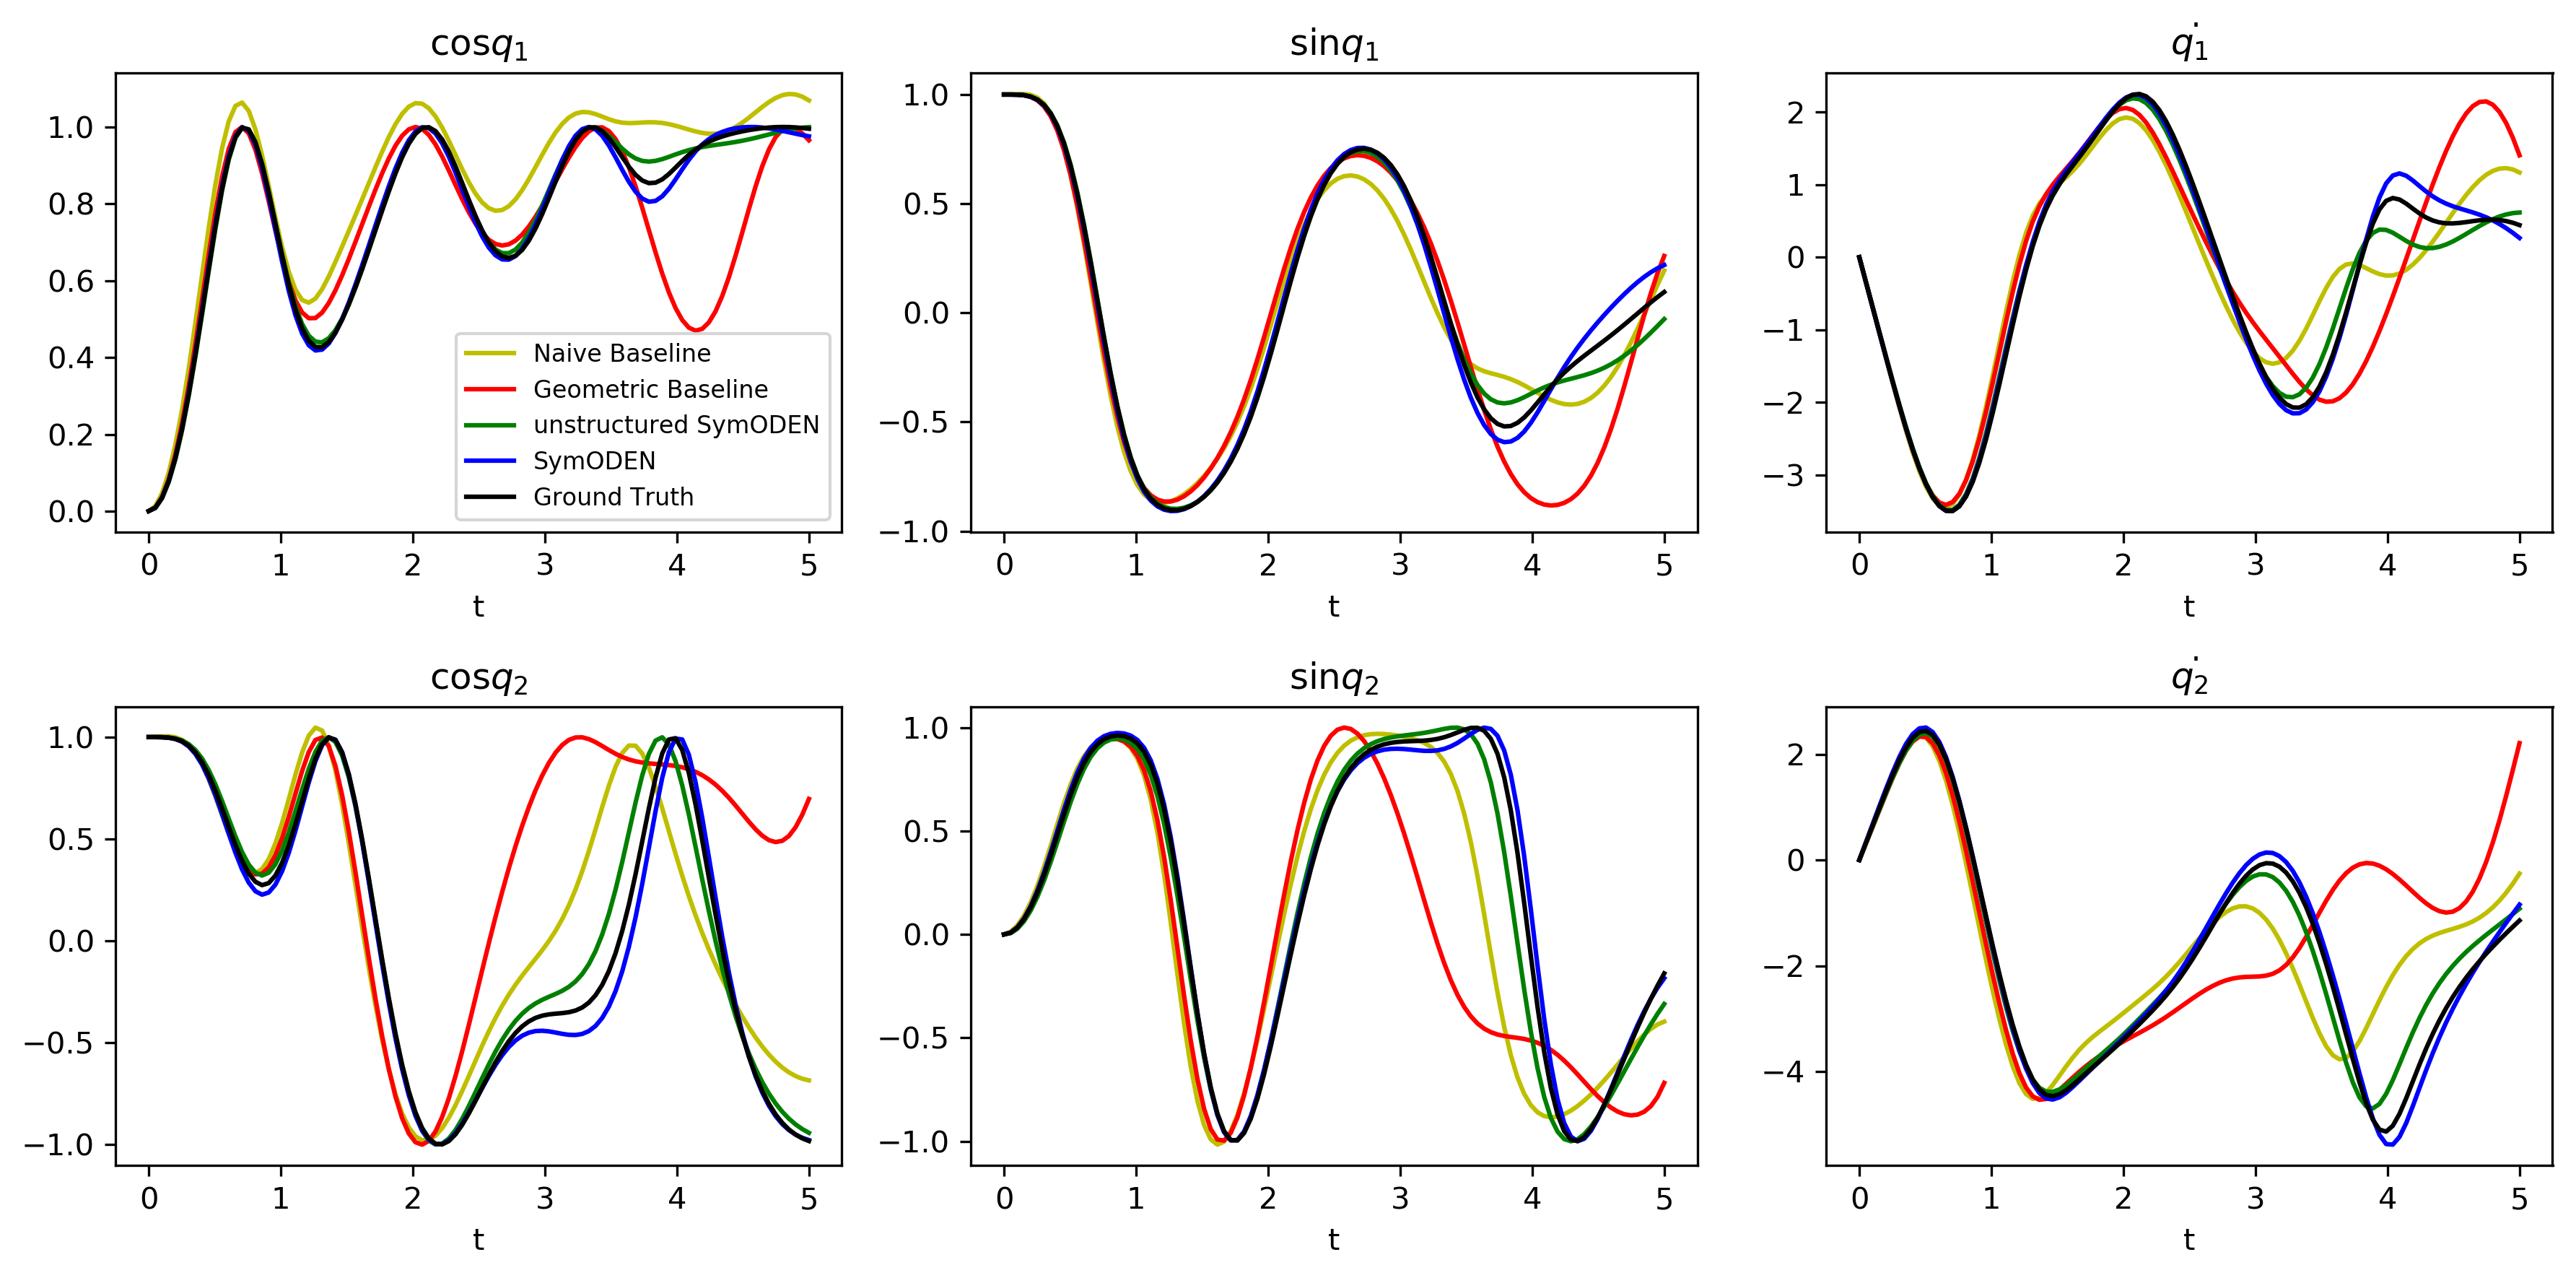

In [9]:
fig = plt.figure(figsize=[12, 6], dpi=DPI)

plt.subplot(2, 3, 1)
plt.plot(t_linspace_model, naive_ivp.y[0,:], 'y', label='Naive Baseline')
plt.plot(t_linspace_model, base_ivp.y[0,:], 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_ivp.y[0,:], 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_ivp.y[0,:], 'b', label='SymODEN')
plt.plot(t_linspace_true, true_ivp[0,:], 'k', label='Ground Truth')
plt.title('$\cos q_1$')
plt.xlabel('t')
plt.legend(fontsize=8)

plt.subplot(2, 3, 2)
plt.plot(t_linspace_model, naive_ivp.y[2,:], 'y', label='Naive Baseline')
plt.plot(t_linspace_model, base_ivp.y[2,:], 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_ivp.y[2,:], 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_ivp.y[2,:], 'b', label='SymODEN')
plt.plot(t_linspace_true, true_ivp[1,:], 'k', label='Ground Truth')
plt.xlabel('t')
plt.title('$\sin q_1$')

plt.subplot(2, 3, 3)
plt.plot(t_linspace_model, naive_ivp.y[4,:], 'y', label='Naive Baseline')
plt.plot(t_linspace_model, base_ivp.y[4,:], 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_ivp.y[4,:], 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_ivp.y[4,:], 'b', label='SymODEN')
plt.plot(t_linspace_true, true_ivp[4,:], 'k', label='Ground Truth')
plt.xlabel('t')
plt.title('$\dot{q_1}$')

plt.subplot(2, 3, 4)
plt.plot(t_linspace_model, naive_ivp.y[1,:], 'y', label='Naive Baseline')
plt.plot(t_linspace_model, base_ivp.y[1,:], 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_ivp.y[1,:], 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_ivp.y[1,:], 'b', label='SymODEN')
plt.plot(t_linspace_true, true_ivp[2,:], 'k', label='Ground Truth')
plt.xlabel('t')
plt.title('$\cos q_2$')

plt.subplot(2, 3, 5)
plt.plot(t_linspace_model, naive_ivp.y[3,:], 'y', label='Naive Baseline')
plt.plot(t_linspace_model, base_ivp.y[3,:], 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_ivp.y[3,:], 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_ivp.y[3,:], 'b', label='SymODEN')
plt.plot(t_linspace_true, true_ivp[3,:], 'k', label='Ground Truth')
plt.xlabel('t')
plt.title('$\sin q_2$')

plt.subplot(2, 3, 6)
plt.plot(t_linspace_model, naive_ivp.y[5,:], 'y', label='Naive Baseline')
plt.plot(t_linspace_model, base_ivp.y[5,:], 'r', label='Geometric Baseline')
plt.plot(t_linspace_model, hnn_ivp.y[5,:], 'g', label='unstructured SymODEN')
plt.plot(t_linspace_model, hnn_struct_ivp.y[5,:], 'b', label='SymODEN')
plt.plot(t_linspace_true, true_ivp[5,:], 'k', label='Ground Truth')
plt.xlabel('t')
plt.title('$\dot{q_2}$')

plt.tight_layout()

